In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.load('../dataset/cv/train/x/generated_text_spaces.npz')['arr_0']
labels = np.load('../dataset/cv/train/y/generated_labels_spaces.npy')

setGPU: Setting GPU to: 0


In [2]:
characters = set(char for label in labels for char in label)

In [3]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [4]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    tmp = np.array([char_to_num(char) for char in label])
    encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0, mode='constant'))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_generated_labels.npy')

In [5]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [6]:
#with strategy.scope():
net = build_and_compile_model_v9_7(input_shape=(180, 32, 1), len_characters=len(characters), opt="Adam")

In [7]:
net.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 32, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 32, 64)       640       
_________________________________________________________________
activation (Activation)      (None, 180, 32, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 32, 64)       256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 32, 64)       36928     
_________________________________________________________________
activation_1 (Activation)    (None, 180, 32, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 180, 32, 64)      

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v9_7_spaces.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [10]:
batch_size = 64
x_train = imgs
y_train = enc2

In [ ]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size, shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 39.6295
Epoch 00001: val_loss improved from inf to 32.25173, saving model to weights/CRNN_v9_7_spaces.h5
125/125 [==============================] - 27s 216ms/step - loss: 39.6295 - val_loss: 32.2517
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 29.3446 ETA: 1s
Epoch 00002: val_loss improved from 32.25173 to 29.94832, saving model to weights/CRNN_v9_7_spaces.h5
125/125 [==============================] - 27s 217ms/step - loss: 29.3446 - val_loss: 29.9483
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 29.2302
Epoch 00003: val_loss improved from 29.94832 to 29.56050, saving model to weights/CRNN_v9_7_spaces.h5
125/125 [==============================] - 28s 221ms/step - loss: 29.2302 - val_loss: 29.5605
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 29.2062
Epoch 00004: val_loss improved from 29.56050 to 29.23753, saving model to weights/CRNN_v9_7_s

Epoch 36/100
125/125 [==============================] - ETA: 0s - loss: 26.7340
Epoch 00036: val_loss did not improve from 29.14605
125/125 [==============================] - 27s 218ms/step - loss: 26.7340 - val_loss: 34.2463
Epoch 37/100
125/125 [==============================] - ETA: 0s - loss: 26.6730
Epoch 00037: val_loss did not improve from 29.14605
125/125 [==============================] - 27s 218ms/step - loss: 26.6730 - val_loss: 34.3995
Epoch 38/100
125/125 [==============================] - ETA: 0s - loss: 26.6122
Epoch 00038: val_loss did not improve from 29.14605
125/125 [==============================] - 27s 217ms/step - loss: 26.6122 - val_loss: 34.6427
Epoch 39/100
125/125 [==============================] - ETA: 0s - loss: 26.5515
Epoch 00039: val_loss did not improve from 29.14605
125/125 [==============================] - 27s 218ms/step - loss: 26.5515 - val_loss: 34.6030
Epoch 40/100
125/125 [==============================] - ETA: 0s - loss: 26.4951
Epoch 00040: val

In [ ]:
np.save('history/my_history_v5.npy',history.history)

In [23]:
import numpy as np
his = np.load('my_history_v5.npy', allow_pickle=True)

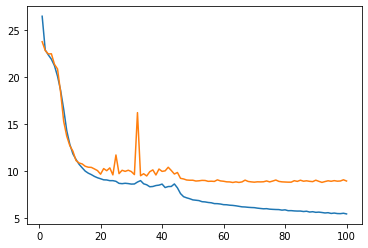

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [14]:
import imageio

im = imageio.imread('../dataset/cv/train/mario.png')

In [15]:
import cv2
from skimage import color

im = cv2.resize(im, (128, 128))
im = color.rgb2gray(im)

<ipython-input-15-d15eb699efec>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im = color.rgb2gray(im)


In [16]:
im = np.expand_dims(im, axis=-1)

In [17]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

In [21]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [22]:
pred_labels

array([[14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [23]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[

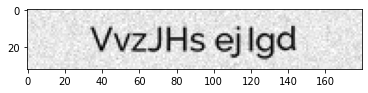

In [53]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0], cmap='gray')
plt.show()

In [15]:
net.load_weights('weights/CRNN_v10_5.h5')

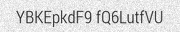

In [49]:
from trdg.generators import GeneratorFromRandom  
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=2, width=180, size=32)
img, lbl = next(base_generator)
display(img)

In [50]:
imgs = []
labels = []
import cv2
from skimage import color
import numpy as np
for _ in range(10000):
    img, lbl = next(base_generator)
    im = color.rgb2gray(np.array(img))
    im = np.expand_dims(im, axis=-1)
    imgs.append(im)
    labels.append(lbl)

In [51]:
imgs = np.array(imgs)

In [54]:
labels = np.array(labels)

In [57]:
#np.savez_compressed('../dataset/cv/train/x/generated_text_spaces', imgs)
np.save('../dataset/cv/train/y/generated_labels_spaces', labels)

In [52]:
imgs.shape

(10000, 32, 180, 1)

In [37]:
img.size

(180, 28)

In [3]:
import cv2
from skimage import color
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)

NameError: name 'np' is not defined

In [30]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [31]:
pred_labels

array([[14, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [32]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'P', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]

In [26]:
labels[50]

'ht'